In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from models import run_model_dep_classification, append_df_metrics, append_df_importances, create_df_importances
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from models import classification_metrics
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pydot
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from models import plot_roc_curve, plot_cm
from models import prune_duplicate_leaves
from models import RoundTransformer

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_models').resolve()

def process_df(df_i, remove_na=True):
    df_i = copy.deepcopy(df_i)

    for c in df_i.columns:
        df_i[c] = df_i[c] / np.max(df_i[c])

    try:
        df_i = df_i.drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1)
    except:
        pass

    if remove_na:
        df_i = df_i.dropna()
    return df_i

# Criação das variaveis de interesse

#### Label

In [2]:
# Target
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))
df = df.dropna(subset=['depression'])
df['depression'].value_counts()

depression
0.0    58451
1.0     6949
Name: count, dtype: int64

#### Features derivadas

In [3]:
# Alimentos in natura ou minimamente processado
innatura = ['P00601','P00602', 'P00603', 'P00604', 'P00605', 'P00607', 'P00608', 'P00609', 'P00610', 'P00611', 'P00612', 'P00613']
df_innatura = df[innatura]
df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
# Alimentos ultraprocessados
ultraprocessados = ['P00614', 'P00615', 'P00616', 'P00617', 'P00618', 'P00619', 'P00620', 'P00621', 'P00622', 'P00623']
df_upf = df[ultraprocessados]
df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)

# A literatura não usa a porcentagem de ultraprocessados do prato como análise. O artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
# Usa como base o número de perguntas respondidas 'Sim' nos alimentos ultraprocessados das ultimas 24hrs
df['per_innatura'] = df_innatura['qst_innatura'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['per_upf'] = df_upf['qst_upf'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['qst_upf'] = df_upf['qst_upf'] # Baseado no artigo

def classify_upf(row):
    value = row['qst_upf']

    if  0 <= value < 2:
        return 1
    elif value < 4:
        return 2
    elif value < 6:
        return 3
    elif value < 8:
        return 4
    elif value <= 10:
        return 5

    return np.nan # questionario não respondido

df['upf_severity'] = df.apply(classify_upf, axis=1)


def count_imc(row):
    height = row['altura']
    weight = row['peso']

    imc = weight/np.square(height/100)   # Peso está em kg e altura em cm, no calculo do imc é kg/m^2
    return imc

df['imc'] = df.apply(count_imc, axis=1)


def classify_imc(row):
    value = row['imc']

    if  0 <= value < 18.5:
        return 1  # Baixo peso
    elif value < 24.9:
        return 2 # Eutrofia/peso adequado
    elif value < 29.9:
        return 3   # Sobrepeso
    elif value >= 30:
        return 4  # Obesidade

    return np.nan # questionario não respondido

df['class_imc'] = df.apply(classify_imc, axis=1)


def classify_idade(row):
    value = row['idade']
    if  18 <= value <= 29:
        return 1
    elif value <= 39:
        return 2
    elif value <= 49:
        return 3
    elif value <= 59:
        return 4

    return np.nan

df['class_idade'] = df.apply(classify_idade, axis=1)


# Essa variável foi criada a partir de um índice utilizado pela OMS. Na literatura, usam a pergunta 'P034' relacionada à prática de exercícios físicos nos ultimos 3 meses
df_activity = pd.DataFrame()
df_activity['minutes_per_week'] = df['P03702'] * df['P035']

vigorous_activities = [3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 15.0]
moderated_activities = [1.0, 2.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 17.0]
df_activity['time_vigorous'] = df_activity['minutes_per_week'].loc[df['P036'].isin(vigorous_activities)]
df_activity['time_moderated'] = df_activity['minutes_per_week'].loc[df['P036'].isin(moderated_activities)]

df_activity['activity_class'] = 0
df_activity.loc[df_activity['minutes_per_week'].isna(), 'activity_class'] = np.nan
df_activity.loc[(df_activity['time_vigorous'] >= 75) | (df_activity['time_moderated'] >= 150), 'activity_class'] = 1

df['activity_class'] = df_activity['activity_class']
df['exerc_fisico'] = np.where(df['P034'].isin([1.0]), 1, np.where(df['P034'] == 2.0, 0, np.nan))
df['tabagismo'] = np.where(df['P050'].isin([1.0, 2.0]), 1, np.where(df['P050'] == 3.0, 0, np.nan))

# Na literatura eles usam outra variável para analisar o consumo alcoolico
# df['cons_alcool'] = np.where(df['P02801'] >= 1, 1, 0)
# df['cons_alcool'] = np.where(df['P02801'].isna(), np.nan, df['cons_alcool'])

# Olhar artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df['cons_alcool'] = np.where(df['P027'].isin([2.0, 3.0]), 1, np.where(df['P027'] == 1.0, 0, np.nan))

df = df[df['P005'] != 1.0] #Retirando as grávidas da análise

df['obesidade'] = np.where(df['class_imc'].isna(), np.nan, np.where(df['class_imc'] >= 4, 1, 0))

# Limitação da análise por idades que se adequam ao PHQ9 baseado no artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df = df[(df['idade'] >= 18) & (df['idade'] <= 59)]


regiao_mapping = {
    'r_norte': [11, 12, 13, 14, 15, 16, 17],
    'r_nordeste': [21, 22, 23, 24, 25, 26, 27, 28, 29],
    'r_sudeste': [31, 32, 33, 35],
    'r_sul': [41, 42, 43],
    'r_centro_oeste': [50, 51, 52, 53]
}

for regiao, estados in regiao_mapping.items():
    df[regiao] = df['uf'].apply(lambda x: int(x in estados))


df['class_renda'] = np.where(df['renda_pc'].isin([4.0, 5.0, 6.0, 7.0]), 1, np.where(df['renda_pc'].isin([1.0, 2.0, 3.0]), 0, np.nan))

/tmp/ipykernel_35742/1486364925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
/tmp/ipykernel_35742/1486364925.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)


In [4]:
df['depression'].value_counts()

depression
0.0    57816
1.0     6848
Name: count, dtype: int64

# Análise de dados faltantes

#### População total

In [5]:
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', df['Q092'].isna().sum(), 'Perc:',  round(df['Q092'].isna().sum()/len(df['Q092'])*100, 3))
print('Faltantes em PHQ9_total - classificação de grau de depressão: ', df['phq9_total'].isna().sum(), 'Perc:',  round(df['phq9_total'].isna().sum()/len(df['phq9_total'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', df['vive_conjugue'].isna().sum(), 'Perc:',  round(df['vive_conjugue'].isna().sum()/len(df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', df['class_idade'].isna().sum(), 'Perc:',  round(df['class_idade'].isna().sum()/len(df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', df['cor'].isna().sum(), 'Perc:',  round(df['cor'].isna().sum()/len(df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', df['upf_severity'].isna().sum(), 'Perc:',  round(df['upf_severity'].isna().sum()/len(df['upf_severity'])*100, 3))
print('Faltantes em exerc_fisico - classificação de atividade física: ', df['exerc_fisico'].isna().sum(), 'Perc:',  round(df['exerc_fisico'].isna().sum()/len(df['exerc_fisico'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', df['tabagismo'].isna().sum(), 'Perc:',  round(df['tabagismo'].isna().sum()/len(df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - classificação do consumo de álcool: ', df['cons_alcool'].isna().sum(), 'Perc:',  round(df['cons_alcool'].isna().sum()/len(df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', df['Q120'].isna().sum(), 'Perc:',  round(df['Q120'].isna().sum()/len(df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', df['Q00201'].isna().sum(), 'Perc:',  round(df['Q00201'].isna().sum()/len(df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', df['Q03001'].isna().sum(), 'Perc:',  round(df['Q03001'].isna().sum()/len(df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', df['Q06306'].isna().sum(), 'Perc:',  round(df['Q06306'].isna().sum()/len(df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', df['Q060'].isna().sum(), 'Perc:',  round(df['Q060'].isna().sum()/len(df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', df['Q068'].isna().sum(), 'Perc:',  round(df['Q068'].isna().sum()/len(df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', df['Q079'].isna().sum(), 'Perc:',  round(df['Q079'].isna().sum()/len(df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', df['class_imc'].isna().sum(), 'Perc:',  round(df['class_imc'].isna().sum()/len(df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em PHQ9_total - classificação de grau de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em exerc_fisico - classificação de atividade física:  0 Perc: 0.0
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - classificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  1495 Perc: 2.312
Faltantes em Q03001 - diagnostico diabetes:  5410 Perc: 8.366
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  6369 Perc: 9.849
Faltantes em Q068 - diagno

## População considerada depressiva (PHQ9>=10)

In [6]:
new_df = df[df['phq9_total'] >= 10].copy()
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', new_df['Q092'].isna().sum(), 'Perc:',  round(new_df['Q092'].isna().sum()/len(new_df['Q092'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', new_df['vive_conjugue'].isna().sum(), 'Perc:',  round(new_df['vive_conjugue'].isna().sum()/len(new_df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', new_df['class_idade'].isna().sum(), 'Perc:',  round(new_df['class_idade'].isna().sum()/len(new_df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', new_df['cor'].isna().sum(), 'Perc:',  round(new_df['cor'].isna().sum()/len(new_df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', new_df['upf_severity'].isna().sum(), 'Perc:',  round(new_df['upf_severity'].isna().sum()/len(new_df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', new_df['activity_class'].isna().sum(), 'Perc:',  round(new_df['activity_class'].isna().sum()/len(new_df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', new_df['tabagismo'].isna().sum(), 'Perc:',  round(new_df['tabagismo'].isna().sum()/len(new_df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', new_df['cons_alcool'].isna().sum(), 'Perc:',  round(new_df['cons_alcool'].isna().sum()/len(new_df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', new_df['Q120'].isna().sum(), 'Perc:',  round(new_df['Q120'].isna().sum()/len(new_df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', new_df['Q00201'].isna().sum(), 'Perc:',  round(new_df['Q00201'].isna().sum()/len(new_df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', new_df['Q03001'].isna().sum(), 'Perc:',  round(new_df['Q03001'].isna().sum()/len(new_df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', new_df['Q06306'].isna().sum(), 'Perc:',  round(new_df['Q06306'].isna().sum()/len(new_df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', new_df['Q060'].isna().sum(), 'Perc:',  round(new_df['Q060'].isna().sum()/len(new_df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', new_df['Q068'].isna().sum(), 'Perc:',  round(new_df['Q068'].isna().sum()/len(new_df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', new_df['Q079'].isna().sum(), 'Perc:',  round(new_df['Q079'].isna().sum()/len(new_df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', new_df['class_imc'].isna().sum(), 'Perc:',  round(new_df['class_imc'].isna().sum()/len(new_df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em activity_class - classificação de atividade física:  4570 Perc: 66.735
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - clasificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  71 Perc: 1.037
Faltantes em Q03001 - diagnostico diabetes:  353 Perc: 5.155
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  443 Perc: 6.469
Faltantes em Q068 - diagnostico de AVC:  0 Perc: 0.0
Faltantes em Q079 - diagnostico de artrite:  

# Modelos

In [7]:
df_metrics_all = pd.DataFrame()
df_importances_all = pd.DataFrame()

### Seleção das variaveis e ajustes

In [8]:
df_total = pd.DataFrame()

df_total['exerc_fisico'] = df['exerc_fisico']
df_total['tabagismo'] = df['tabagismo']
df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensao'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['estado_civil'] = df['vive_conjugue']
df_total = df_total.replace(2.0, 0.0)

df_total['class_renda'] = df['class_renda']
df_total['r_norte'] = df['r_norte']
df_total['r_nordeste'] = df['r_nordeste']
df_total['r_sudeste'] = df['r_sudeste']
df_total['r_sul'] = df['r_sul']
df_total['r_centro_oeste'] = df['r_centro_oeste']
df_total['escolaridade'] = df['escolaridade_agregada']
df_total['upf'] = df['qst_upf']
df_total['class_idade'] = df['class_idade']

df_train_total, df_test_total = train_test_split(df_total, test_size=0.3, random_state=42)

df_total_t = copy.deepcopy(df_total)

print("Número de dados totais: ", len(df_total_t))
print("Número de dados filtrados: ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes: {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

print()

df_total_t = copy.deepcopy(df_train_total)
print("Número de dados totais (treino): ", len(df_total_t))
print("Número de dados filtrados (treino): ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes (treino): {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

print()

df_total_t = copy.deepcopy(df_test_total)
print("Número de dados totais (teste): ", len(df_total_t))
print("Número de dados filtrados (teste): ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes (teste): {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

Número de dados totais:  64664
Número de dados filtrados:  49843
Porcentagem de dados faltantes: 22.92

Número de dados totais (treino):  45264
Número de dados filtrados (treino):  34932
Porcentagem de dados faltantes (treino): 22.83

Número de dados totais (teste):  19400
Número de dados filtrados (teste):  14911
Porcentagem de dados faltantes (teste): 23.14


In [9]:
data = []
for x in df_total.columns:
    data.append([x, df_total[x].isna().sum()])

pd.DataFrame(data)

,0,1
0,exerc_fisico,0
1,tabagismo,0
2,cons_alcool,0
3,cancer,0
4,hipertensao,1495
5,diabetes,5410
6,cardiovascular,0
7,hipercolesterolemia,6369
8,avc,0
9,artrite,0


### Modelo apenas com habitos

In [10]:
df_habitos = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'depression']].dropna()
df_habitos = process_df(df_habitos)

X = df_habitos.drop('depression', axis=1)
y = df_habitos['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.559495,0.5568,0.004056,0.129505,0.129419,0.004002,0.547017,0.550957,0.017824,0.209429,0.209602,0.006519,0.554001,0.554228,0.009659


,value
name,
intercept,0.088590
upf,0.328529
exerc_fisico,-0.311042
tabagismo,0.426634
cons_alcool,-0.257471


### Modelo apenas com as doenças cronicas

In [11]:
df_doencas = df_train_total[['cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()

df_doencas = process_df(df_doencas)
X = df_doencas.drop('depression', axis=1)
y = df_doencas['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.728369,0.718348,0.020054,0.189948,0.186161,0.006638,0.443285,0.453719,0.02684,0.265941,0.263577,0.004461,0.603625,0.602554,0.003663


,value
name,
intercept,-0.359667
cancer,0.598822
hipertensao,0.332995
diabetes,0.442612
cardiovascular,0.817326
hipercolesterolemia,0.415578
avc,0.827416
artrite,0.970965
obesidade,0.171847


### Modelo com doenças e hábitos

In [12]:
df_total = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()

df_total = process_df(df_total)
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.694928,0.697396,0.002415,0.18432,0.185758,0.002139,0.510436,0.510212,0.008782,0.27084,0.272349,0.003355,0.6142,0.61549,0.003772


,value
name,
intercept,-0.374872
upf,0.506591
exerc_fisico,-0.268770
tabagismo,0.496912
cons_alcool,-0.168661
cancer,0.610780
hipertensao,0.320164
diabetes,0.426784
cardiovascular,0.793659


### Modelo só com variáveis sociodemográficas

In [13]:
df_total = df_train_total[['sexo', 'estado_civil', 'escolaridade', 'class_idade', 'class_renda', 'depression']].dropna()
df_total = process_df(df_total)
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_sociodemo')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_sociodemo')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.570528,0.565586,0.005619,0.158095,0.157008,0.001924,0.697077,0.700613,0.01118,0.257736,0.25652,0.003005,0.626224,0.625013,0.004642


,value
name,
intercept,0.500974
sexo,-1.053469
estado_civil,-0.393739
escolaridade,-0.173576
class_idade,0.478322
class_renda,-0.262069


### Modelo com todas as variáveis de interesse

#### Correlações

In [14]:
variables_names = {
    'upf': 'Ultraprocessados',
    'exerc_fisico': 'Exercício Físico',
    'tabagismo': 'Tabagismo',
    'cons_alcool': 'Consumo Álcool',
    'cancer': 'Câncer',
    'hipertensao': 'Hipertensão',
    'diabetes': 'Diabetes',
    'cardiovascular': 'Cardiovascular',
    'hipercolesterolemia': 'Hipercolesterolemia',
    'avc': 'AVC',
    'artrite': 'Artrite',
    'obesidade': 'Obesidade',
    'sexo': 'Sexo',
    'estado_civil': 'Estado Civil',
    'escolaridade': 'Classificação Escolaridade',
    'class_idade': 'Classificação Idade',
    'class_renda': 'Classificação Renda',
    'depression': 'Depressão'
}


In [15]:
df_total

,sexo,estado_civil,escolaridade,class_idade,class_renda,depression
87359,1.0,1.0,0.50,0.25,0.0,0.0
86565,0.0,1.0,0.25,0.75,0.0,0.0
9042,1.0,1.0,0.75,1.00,1.0,0.0
81571,0.0,0.0,0.50,0.25,0.0,0.0
82260,0.0,1.0,0.25,0.75,0.0,0.0
...,...,...,...,...,...,...
87924,0.0,0.0,0.50,0.25,0.0,0.0
53604,1.0,0.0,0.25,0.75,0.0,0.0
1203,1.0,1.0,0.50,1.00,0.0,1.0
22293,0.0,1.0,0.25,0.50,0.0,0.0


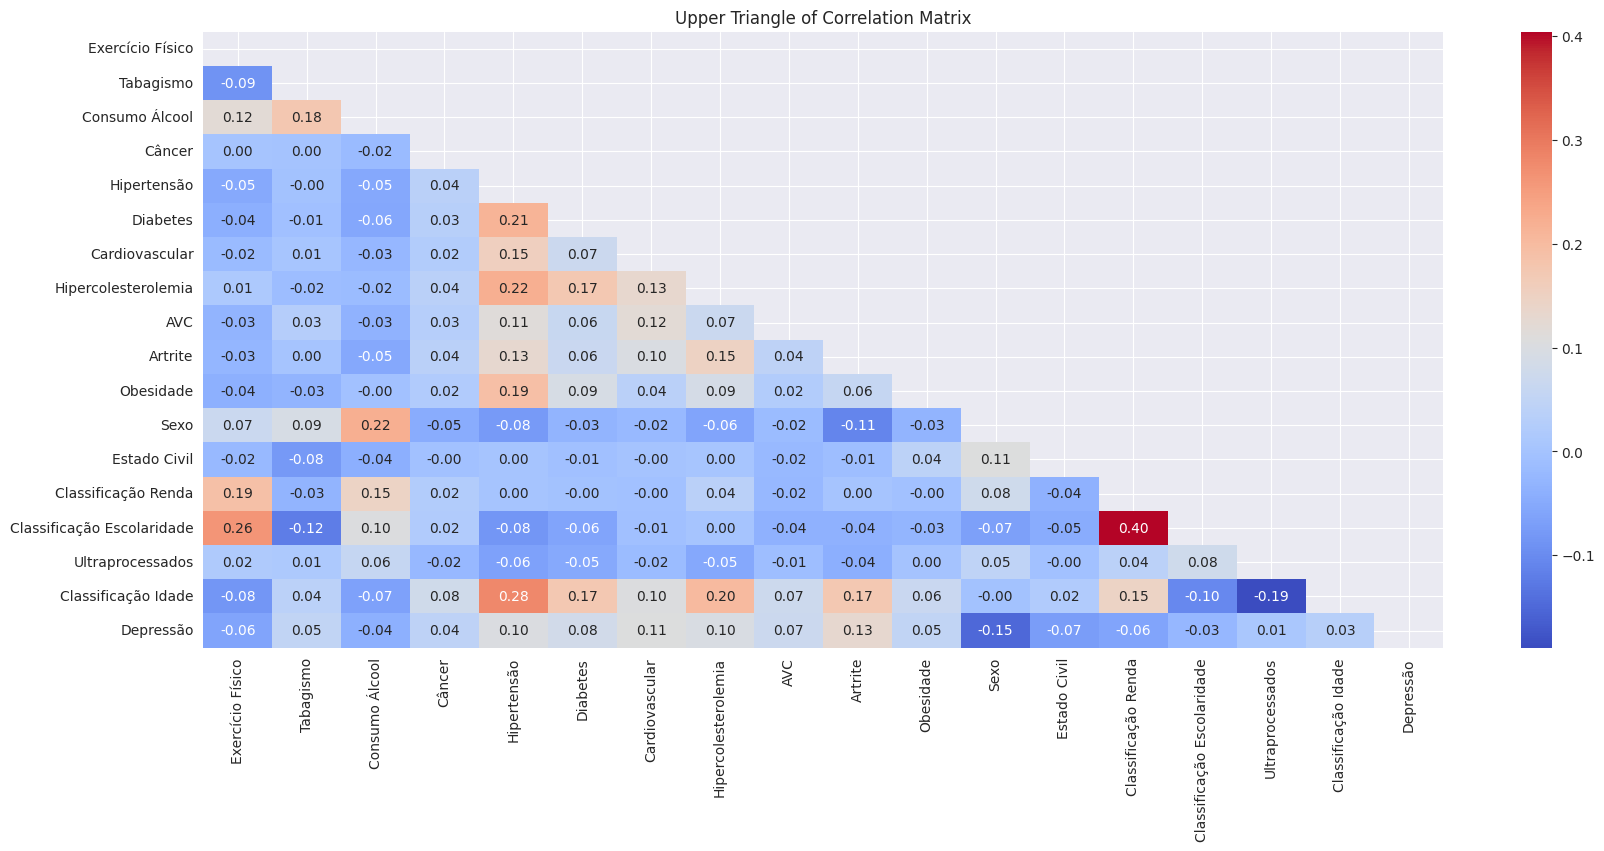

In [16]:
df_total = process_df(df_train_total)
df_total = df_total.rename(columns=variables_names)

df_total = df_total[[col for col in df_total.columns if col != 'Depressão'] + ['Depressão']]
corr_matrix = df_total.corr()
correlations = corr_matrix['Depressão'].abs().sort_values(ascending=False)

mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Upper Triangle of Correlation Matrix")
fig.savefig(PATH_GEN_DATA / 'personr_matrix.png')
plt.show()

In [17]:
from scipy import stats

data = []
for c in df_total.columns: 
    corr, p_value = stats.pearsonr(df_total[c], df_total['Depressão'])
    data.append([c, corr, p_value])

df = pd.DataFrame(data, columns=['var', 'r', 'p'])

df.to_excel(PATH_GEN_DATA / 'pearson_r.xlsx')
df

,var,r,p
0,Exercício Físico,-0.059380,1.152464e-28
1,Tabagismo,0.052019,2.275121e-22
2,Consumo Álcool,-0.038470,6.361858e-13
3,Câncer,0.043146,7.171473e-16
4,Hipertensão,0.102234,8.428878e-82
5,Diabetes,0.080024,9.905031e-51
6,Cardiovascular,0.107613,1.765719e-90
7,Hipercolesterolemia,0.098234,1.222190e-75
8,AVC,0.068793,6.449094e-38
9,Artrite,0.130409,2.576811e-132


In [18]:
correlations.head(30)

Depressão                     1.000000
Sexo                          0.151905
Artrite                       0.130409
Cardiovascular                0.107613
Hipertensão                   0.102234
Hipercolesterolemia           0.098234
Diabetes                      0.080024
Estado Civil                  0.072990
AVC                           0.068793
Exercício Físico              0.059380
Classificação Renda           0.059227
Tabagismo                     0.052019
Obesidade                     0.049887
Câncer                        0.043146
Consumo Álcool                0.038470
Classificação Idade           0.033487
Classificação Escolaridade    0.025452
Ultraprocessados              0.008848
Name: Depressão, dtype: float64

#### Exluindo todos dados nulos

In [19]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_dropna')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_dropna')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.657993,0.658994,0.009068,0.192886,0.19283,0.007164,0.647949,0.644615,0.027019,0.297277,0.29682,0.010868,0.653602,0.652708,0.013547


,value
name,
intercept,0.304565
exerc_fisico,-0.227836
tabagismo,0.571180
cons_alcool,-0.022888
cancer,0.514918
hipertensao,0.345127
diabetes,0.496596
cardiovascular,0.875216
hipercolesterolemia,0.464894


In [20]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_dropna')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_dropna')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.657993,0.658994,0.009068,0.192886,0.19283,0.007164,0.647949,0.644615,0.027019,0.297277,0.29682,0.010868,0.653602,0.652708,0.013547


,value
name,
intercept,0.304565
exerc_fisico,-0.227836
tabagismo,0.571180
cons_alcool,-0.022888
cancer,0.514918
hipertensao,0.345127
diabetes,0.496596
cardiovascular,0.875216
hipercolesterolemia,0.464894


#### Usando a media/mediana

In [21]:
df_total = process_df(df_train_total, remove_na=False)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_meanimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_meanimp')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.650959,0.652616,0.007747,0.183304,0.184031,0.004991,0.657622,0.657005,0.01916,0.286695,0.287499,0.007481,0.653893,0.654549,0.009644


,value
name,
intercept,0.275150
exerc_fisico,-0.217977
tabagismo,0.544545
cons_alcool,0.001818
cancer,0.523474
hipertensao,0.350096
diabetes,0.463612
cardiovascular,0.890629
hipercolesterolemia,0.454538


In [22]:
df_total = process_df(df_train_total, remove_na=False)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_medianimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_medianimp')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.652748,0.65414,0.007706,0.184311,0.184766,0.004766,0.658451,0.657004,0.019413,0.288005,0.288393,0.007162,0.655259,0.655402,0.009307


,value
name,
intercept,0.298513
exerc_fisico,-0.220772
tabagismo,0.549925
cons_alcool,0.002333
cancer,0.521065
hipertensao,0.358364
diabetes,0.479424
cardiovascular,0.883006
hipercolesterolemia,0.474465


### Testando SMOTE

In [23]:

# o SMOTE é uma possibilidade para podermos realizar data augmentation dos dados de pessoas consideradas depressivas
# O desbalanceio das classes é ENORME (~59k não depressivos e 7k depressivos)
# Ele olha a classe com menos quantidade de amostras e gera uma nova distribuição de acordo com as semelhanças entre vizinhos

df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('smt', SMOTE(sampling_strategy='auto', random_state=42)),
    ('reg', LogisticRegression(max_iter=1000, class_weight=None, random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_smote')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_smote')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.641589,0.63864,0.008775,0.188584,0.18682,0.005295,0.669231,0.666923,0.022882,0.29425,0.291843,0.008074,0.653673,0.651005,0.010629


,value
name,
intercept,0.458610
exerc_fisico,-0.234560
tabagismo,0.521447
cons_alcool,-0.010848
cancer,0.250395
hipertensao,0.365556
diabetes,0.353119
cardiovascular,0.757237
hipercolesterolemia,0.436805


### Ajuste Hyper-parametro

In [24]:
df_total =  process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'reg__C': [0.1, 1.0, 10.0],
    'reg__solver': ['liblinear', 'saga'],
    'reg__max_iter': [100, 500, 1000]
}


model = Pipeline([
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_log = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_log, df_metrics = run_model_dep_classification(model_log, X, y)
df_importances = create_df_importances(X.columns, model_log.named_steps['reg'].coef_[0],  model_log.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_best_grid')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_best_grid')

Best params: 
{'reg__C': 0.1, 'reg__max_iter': 100, 'reg__solver': 'liblinear'}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.65742,0.658393,0.008791,0.192451,0.192852,0.006938,0.647179,0.64641,0.025453,0.296679,0.29704,0.010469,0.652943,0.653155,0.012983


,value
name,
intercept,0.298128
exerc_fisico,-0.226481
tabagismo,0.564436
cons_alcool,-0.022984
cancer,0.483865
hipertensao,0.346219
diabetes,0.486332
cardiovascular,0.852712
hipercolesterolemia,0.462442


### Variação fatores ao longo do curso da vida e de variaveis sociodemográficas

In [25]:
df_total = process_df(df_train_total)
df_total_raw = copy.deepcopy(df_train_total)

tests = {

    'log_class_renda_baixa': df_total[df_total['class_renda'] == 0.0].drop('class_renda', axis=1),
    'log_class_renda_alta': df_total[df_total['class_renda'] == 1.0].drop('class_renda', axis=1),

    'log_class_sexo_mulher': df_total[df_total['sexo'] == 0].drop('sexo', axis=1),
    'log_class_sexo_homem': df_total[df_total['sexo'] == 1].drop('sexo', axis=1),

    'log_class_idade_less40': process_df(df_total_raw[df_total_raw['class_idade'] <= 2].drop('class_idade', axis=1)),
    'log_class_idade_more40': process_df(df_total_raw[df_total_raw['class_idade'] > 2].drop('class_idade', axis=1)),

    'log_class_idade1': process_df(df_total_raw[df_total_raw['class_idade'] == 1].drop('class_idade', axis=1)),
    'log_class_idade2': process_df(df_total_raw[df_total_raw['class_idade'] == 2].drop('class_idade', axis=1)),
    'log_class_idade3': process_df(df_total_raw[df_total_raw['class_idade'] == 3].drop('class_idade', axis=1)),
    'log_class_idade4': process_df(df_total_raw[df_total_raw['class_idade'] == 4].drop('class_idade', axis=1)),


    'log_class_r_norte': process_df(df_total_raw[df_total_raw['r_norte'] == 1]),
    'log_class_r_nordeste': process_df(df_total_raw[df_total_raw['r_nordeste'] == 1]),
    'log_class_r_sudeste': process_df(df_total_raw[df_total_raw['r_sudeste'] == 1]),
    'log_class_r_sul': process_df(df_total_raw[df_total_raw['r_sul'] == 1]),
    'log_class_r_centro_oeste': process_df(df_total_raw[df_total_raw['r_centro_oeste'] == 1]),

}
for key, df_selected in tests.items():
    X = df_selected.drop('depression', axis=1)
    y = df_selected['depression']

    model = Pipeline([
        ('reg', LogisticRegression(max_iter=100, class_weight='balanced', solver='liblinear', C=10, random_state=42))
    ])

    model, df_metrics = run_model_dep_classification(model, X, y)
    df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

    df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, key)
    df_importances_all = append_df_importances(df_importances_all, df_importances, key)

    print("{}: {}, f1: {}".format(key, len(df_selected)/ len(df_total), df_metrics['test_f1'][0]))


log_class_renda_baixa: 0.5598877819764113, f1: 0.3244666476949908
log_class_renda_alta: 0.4401122180235887, f1: 0.24066453668550225
log_class_sexo_mulher: 0.5387037673193633, f1: 0.33247310888254694
log_class_sexo_homem: 0.4612962326806367, f1: 0.18245793434180818
log_class_idade_less40: 0.46281346616283064, f1: 0.2538026854790294
log_class_idade_more40: 0.5371865338371694, f1: 0.32767223406978885
log_class_idade1: 0.18444406275048666, f1: 0.24933619222017261
log_class_idade2: 0.278369403412344, f1: 0.2619159071144459
log_class_idade3: 0.274962784839116, f1: 0.316220428482809
log_class_idade4: 0.26222374899805334, f1: 0.34567644032402906
log_class_r_norte: 0.18759303790221002, f1: 0.2685948061190908
log_class_r_nordeste: 0.34372495133402037, f1: 0.30277958040757846
log_class_r_sudeste: 0.2232050841635177, f1: 0.31024982589767747
log_class_r_sul: 0.12550097331959234, f1: 0.2797049762502483
log_class_r_centro_oeste: 0.11997595328065956, f1: 0.2932619287323167


## Arvore de Decisão

In [26]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('trans', RoundTransformer()),
    ('class', DecisionTreeClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_dt = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_dt, df_metrics = run_model_dep_classification(model_dt, X, y)
df_importances = create_df_importances(X.columns, model_dt.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'dt_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'dt_exp')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/home/anderso

Best params: 
{'class__criterion': 'gini', 'class__max_depth': None, 'class__min_samples_leaf': 0.01, 'class__min_samples_split': 0.04}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.626446,0.63074,0.007974,0.181464,0.181143,0.004115,0.668205,0.655385,0.022608,0.285417,0.2838,0.006541,0.644701,0.641514,0.009028


,value
name,
exerc_fisico,0.020251
tabagismo,0.065276
cons_alcool,0.011439
cancer,0.000000
hipertensao,0.119663
diabetes,0.000000
cardiovascular,0.000000
hipercolesterolemia,0.058947
avc,0.000000


In [27]:
dot_data = tree.export_graphviz(model_dt.named_steps['class'], out_file=None,
                                feature_names=X.columns,
                                class_names=['False', 'True'],
                                filled=True, proportion=True)
# Draw graph
graph = pydot.graph_from_dot_data(dot_data)[0]
graph.write_svg(PATH_GEN_DATA/"decistion_tree.svg")

In [28]:
model = copy.deepcopy(model_dt)
prune_duplicate_leaves(model.named_steps['class'])

dot_data = tree.export_graphviz(model.named_steps['class'], out_file=None,
                                feature_names=X.columns,
                                class_names=['False', 'True'],
                                filled=True, proportion=True)
# Draw graph
graph = pydot.graph_from_dot_data(dot_data)[0]
graph.write_svg(PATH_GEN_DATA/"decistion_tree_p.svg")

In [29]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('trans', RoundTransformer()),
    ('class', RandomForestClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_rf = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_rf, df_metrics = run_model_dep_classification(model_rf, X, y)
df_importances = create_df_importances(X.columns, model_rf.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'rf_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'rf_exp')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File 

Best params: 
{'class__criterion': 'gini', 'class__max_depth': None, 'class__min_samples_leaf': 0.01, 'class__min_samples_split': 0.01}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
0,0.598076,0.600996,0.013296,0.177193,0.176273,0.004115,0.71359,0.700256,0.023867,0.283893,0.281579,0.005843,0.648574,0.644389,0.008279


,value
name,
exerc_fisico,0.032724
tabagismo,0.035685
cons_alcool,0.010115
cancer,0.000000
hipertensao,0.106566
diabetes,0.017128
cardiovascular,0.027185
hipercolesterolemia,0.081603
avc,0.000000


### Salvando/exibindo tabelas criadas

In [30]:
df_metrics_all.to_excel(PATH_GEN_DATA / 'metrics.xlsx')
df_metrics_all

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std,train_auc,test_auc,test_auc_std
log_apenas_habitos,0.559495,0.556800,0.004056,0.129505,0.129419,0.004002,0.547017,0.550957,0.017824,0.209429,0.209602,0.006519,0.554001,0.554228,0.009659
log_apenas_dcnt,0.728369,0.718348,0.020054,0.189948,0.186161,0.006638,0.443285,0.453719,0.026840,0.265941,0.263577,0.004461,0.603625,0.602554,0.003663
log_apenas_habitos_dcnt,0.694928,0.697396,0.002415,0.184320,0.185758,0.002139,0.510436,0.510212,0.008782,0.270840,0.272349,0.003355,0.614200,0.615490,0.003772
log_apenas_sociodemo,0.570528,0.565586,0.005619,0.158095,0.157008,0.001924,0.697077,0.700613,0.011180,0.257736,0.256520,0.003005,0.626224,0.625013,0.004642
log_all_dropna,0.657993,0.658994,0.009068,0.192886,0.192830,0.007164,0.647949,0.644615,0.027019,0.297277,0.296820,0.010868,0.653602,0.652708,0.013547
log_all_meanimp,0.650959,0.652616,0.007747,0.183304,0.184031,0.004991,0.657622,0.657005,0.019160,0.286695,0.287499,0.007481,0.653893,0.654549,0.009644
log_all_medianimp,0.652748,0.654140,0.007706,0.184311,0.184766,0.004766,0.658451,0.657004,0.019413,0.288005,0.288393,0.007162,0.655259,0.655402,0.009307
log_all_smote,0.641589,0.638640,0.008775,0.188584,0.186820,0.005295,0.669231,0.666923,0.022882,0.294250,0.291843,0.008074,0.653673,0.651005,0.010629
log_best_grid,0.657420,0.658393,0.008791,0.192451,0.192852,0.006938,0.647179,0.646410,0.025453,0.296679,0.297040,0.010469,0.652943,0.653155,0.012983
log_class_renda_baixa,0.652623,0.654463,0.006514,0.216656,0.216504,0.005722,0.653769,0.647396,0.020052,0.325457,0.324467,0.008500,0.653112,0.651450,0.010002


In [31]:
df_importances_all.to_excel(PATH_GEN_DATA / 'importances.xlsx')
df_importances_all

,log_apenas_habitos,log_apenas_dcnt,log_apenas_habitos_dcnt,log_apenas_sociodemo,log_all_dropna,log_all_meanimp,log_all_medianimp,log_all_smote,log_best_grid,log_class_renda_baixa,...,log_class_idade2,log_class_idade3,log_class_idade4,log_class_r_norte,log_class_r_nordeste,log_class_r_sudeste,log_class_r_sul,log_class_r_centro_oeste,dt_exp,rf_exp
name,,,,,,,,,,,,,,,,,,,,,
intercept,0.088590,-0.359667,-0.374872,0.500974,0.304565,0.275150,0.298513,0.458610,0.298128,-0.053712,...,0.161438,0.230761,0.032283,-0.079148,0.277321,0.232176,0.421947,0.997833,NaN,NaN
upf,0.328529,NaN,0.506591,NaN,0.488938,0.581349,0.578550,0.390483,0.476389,0.467706,...,0.550284,0.559828,0.240635,0.806029,0.612443,0.281298,0.535417,0.109156,0.000000,0.001353
exerc_fisico,-0.311042,NaN,-0.268770,NaN,-0.227836,-0.217977,-0.220772,-0.234560,-0.226481,-0.149981,...,-0.160499,-0.223348,-0.523028,-0.030163,-0.206437,-0.301171,-0.247038,-0.434025,0.020251,0.032724
tabagismo,0.426634,NaN,0.496912,NaN,0.571180,0.544545,0.549925,0.521447,0.564436,0.597071,...,0.674224,0.480324,0.517044,0.433562,0.599259,0.573506,0.575814,0.642666,0.065276,0.035685
cons_alcool,-0.257471,NaN,-0.168661,NaN,-0.022888,0.001818,0.002333,-0.010848,-0.022984,-0.063174,...,0.097290,-0.085406,-0.238172,0.233647,-0.136943,0.006487,-0.132889,-0.023134,0.011439,0.010115
cancer,NaN,0.598822,0.610780,NaN,0.514918,0.523474,0.521065,0.250395,0.483865,0.581151,...,0.426074,0.548932,0.555809,0.619839,0.523529,0.500805,0.809114,-0.002149,0.000000,0.000000
hipertensao,NaN,0.332995,0.320164,NaN,0.345127,0.350096,0.358364,0.365556,0.346219,0.320785,...,0.536429,0.322323,0.224113,0.367784,0.399363,0.212829,0.441794,0.324340,0.119663,0.106566
diabetes,NaN,0.442612,0.426784,NaN,0.496596,0.463612,0.479424,0.353119,0.486332,0.497354,...,0.212610,0.705604,0.472489,0.655490,0.431116,0.420205,0.508909,0.514464,0.000000,0.017128
cardiovascular,NaN,0.817326,0.793659,NaN,0.875216,0.890629,0.883006,0.757237,0.852712,0.944466,...,0.989011,0.684343,0.845490,0.986678,0.951050,1.010861,0.396065,0.762513,0.000000,0.027185


In [32]:
from table_gen import gen_metrics_table, gen_coef_table
gen_metrics_table(df_metrics_all, PATH_GEN_DATA / 'tables.md')
gen_coef_table(df_importances_all, PATH_GEN_DATA / 'tables_imp.md')

# Comparando modelos

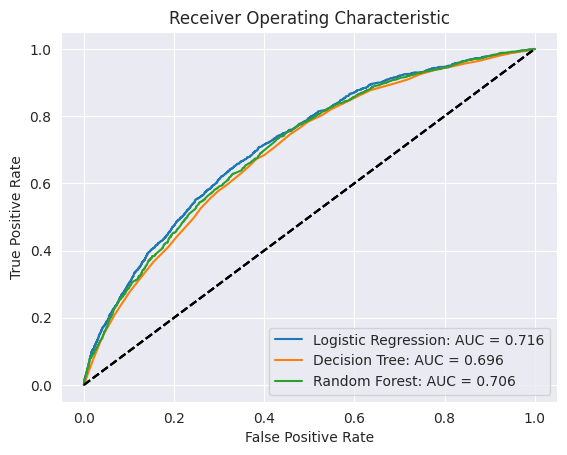

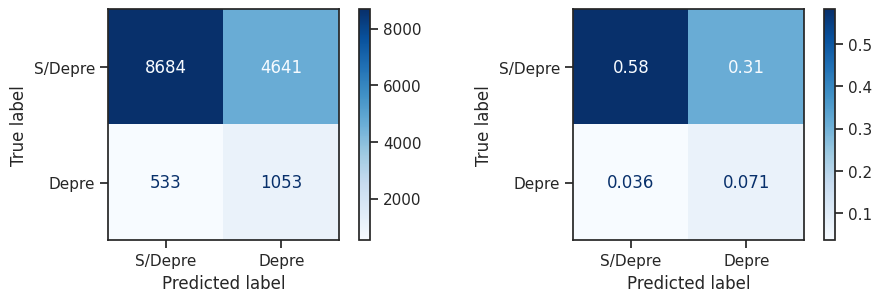

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
exp,,,,,,,,,,
Logistic Regression,65.74%,65.30%,19.25%,18.49%,64.72%,66.39%,29.67%,28.93%,71.40%,71.57%
Decision Tree,62.64%,62.32%,18.15%,17.29%,66.82%,67.21%,28.54%,27.51%,69.95%,69.56%
Random Forest,59.81%,59.17%,17.72%,16.90%,71.36%,72.45%,28.39%,27.40%,70.95%,70.55%


In [33]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

df_test =  process_df(df_test_total)
X_test = df_test.drop('depression', axis=1)
y_test = df_test['depression']

modeldict = {'Logistic Regression': model_log, 'Decision Tree': model_dt, 'Random Forest': model_rf}

plot_roc_curve(modeldict, X_test, y_test, path=PATH_GEN_DATA/'roc.png')
plot_cm(model_log, X_test, y_test, path=PATH_GEN_DATA/'cm.png')

metrics_test = classification_metrics(modeldict, X, y, X_test, y_test)
metrics_test = metrics_test[['exp', 'accuracy_train', 'accuracy_test', 'precision_train', 'precision_test', 'recall_train', 'recall_test', 'f1_train', 'f1_test', 'auc_train', 'auc_test']]

metrics_test = metrics_test.set_index('exp')

metrics_test = metrics_test * 100
for c in metrics_test.columns:
    try:
        metrics_test[c] = metrics_test[c].map('{:.2f}%'.format).astype(str)
    except:
        pass

with open(PATH_GEN_DATA / 'test_metrics.md', 'w') as file:
    file.write(metrics_test.T.to_markdown(floatfmt=".2f") + "\n\n")

metrics_test.to_excel(PATH_GEN_DATA / 'test_metrics.xlsx')
metrics_test